#Import

In [2]:
!pip install -q keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, LSTM, GRU
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns

checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#model.load_weights(checkpoint_dir + checkpoint_name)

# Functions

In [6]:
def mae_plot(plot_name, hist_df):
  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(data=hist_df['mae'], label='Train MAE', color='lightblue')
  ax = sns.lineplot(data=hist_df['val_mae'], label='Valid. MAE', color='steelblue')
  ax.set_xlim(0, len(hist_df)-1)
  ax.set_title('График значения метрики MAE\nдля тренировочной и валидационной выборки', fontsize=12, fontweight='bold')
  ax.set_xlabel('Номер эпохи', fontsize=12)
  ax.set_ylabel('Значение метрики MAE', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/' + plot_name + '.png')

def scatter_plot(y_test, y_pred, lim_value, plot_name):
  y_pred_list = []
  for i in range(len(y_pred)):
    y_pred_list.append(y_pred[i][0])

  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.scatterplot(x=y_test, y=y_pred_list, alpha=0.5)
  ax = sns.lineplot(x=[0, lim_value], y=[0, lim_value], color='black')
  ax.set_xlim(0, lim_value)
  ax.set_ylim(0, lim_value)
  ax.set_title('График соответсвия истинных значений предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Истинные значения', fontsize=12)
  ax.set_ylabel('Предсказанные значения', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/scatter_plot/' + plot_name + '.png')

def line_plot(y_test, y_pred, plot_value, plot_name):
  y_pred_list = []
  for i in range(plot_value+1):
    y_pred_list.append(y_pred[i][0])

  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(y_test[:plot_value], label='Истинные данные', color='steelblue')
  ax = sns.lineplot(y_pred_list, label='Предсказанные данные', color='red')
  ax.set_xlim(0, plot_value)
  ax.set_title('График соответсвия истинных данных предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Количество данных', fontsize=12)
  ax.set_ylabel('Значение данных', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/line_plot/' + plot_name + '.png')

def print_metrics(y_test, y_pred, X_train, csv_name):
  test_results = {}
  test_results['train_size0'] = X_train.shape[0]
  test_results['train_size1'] = X_train.shape[1]
  test_results['lmbd_val'] = y_test.max()
  test_results['mse'] = mean_squared_error(y_test, y_pred)
  test_results['mae'] = mean_absolute_error(y_test, y_pred)
  test_results['r2'] = r2_score(y_test, y_pred)
  print(test_results)
  if csv_name != None:
    metrics_df = pd.DataFrame(test_results, index=['metrics']).T
    metrics_df.to_csv('/content/drive/MyDrive/maga/metrics/' + csv_name + '.csv')

def save_load_history(history, history_dir, save_flag):
  if save_flag:
    hist_df = pd.DataFrame(history.history)
    with open('/content/drive/MyDrive/maga/history/history_' + history_dir, mode='w') as f:
      hist_df.to_csv(f)
  else:
    hist_df = pd.read_csv('/content/drive/MyDrive/maga/history/history_' + history_dir, sep=',', engine='python', index_col=0)
    return hist_df

# Read and split data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/maga/dataset/dataset_pois1.csv', sep=',', index_col=0)

In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,lmbd_value
0,0.000036,0.000122,0.000134,0.000014,0.000074,0.000121,0.000049,0.000018,0.000032,0.000030,...,0.000073,0.000188,0.000102,0.000094,0.000014,0.000053,0.000029,0.000521,0.000136,8971.049526
1,0.000121,0.000273,0.000033,0.000011,0.000051,0.000297,0.000226,0.000133,0.000092,0.000140,...,0.000765,0.000262,0.000007,0.000235,0.000058,0.000026,0.000108,0.000303,0.000595,6887.864137
2,0.000175,0.000068,0.000817,0.001341,0.001101,0.001190,0.000447,0.001354,0.001768,0.000003,...,0.001311,0.000881,0.000279,0.000050,0.002106,0.000284,0.000109,0.000340,0.000306,1612.640689
3,0.000100,0.000614,0.000009,0.000100,0.000119,0.000398,0.000342,0.000128,0.000090,0.000046,...,0.000084,0.000034,0.000191,0.000367,0.000082,0.000156,0.000033,0.000054,0.000228,5025.140444
4,0.000279,0.000646,0.000603,0.000048,0.000497,0.000188,0.000893,0.000284,0.000376,0.000167,...,0.000061,0.000180,0.002526,0.000888,0.000781,0.000432,0.000705,0.000129,0.000149,2480.162679


In [ ]:
X = df.drop('lmbd_value', axis=1)
#X = df.iloc[0:50000, 0:1000]
y = df['lmbd_value']
#y = y.iloc[0:50000]

In [ ]:
X, y = np.array(X), np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1000), (2000, 1000), (8000,), (2000,))

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# My model

In [ ]:
checkpoint_name = '/pois_reg_DNN_3layers_50epochs'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + checkpoint_name,
                                                 save_weights_only=False,
                                                 verbose=1)

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               128128    
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 152,961
Trainable params: 152,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def myprint(s):
    with open('/content/drive/MyDrive/maga/model_summary/pois_reg_DNN_3layers_50epochs.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=myprint)

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.03), loss = 'mse', metrics = ['mae'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=150,
                    validation_split=0.2, shuffle=True, verbose=2, callbacks=[stop_early])

Epoch 1/150
200/200 - 4s - loss: 18082968.0000 - mae: 3060.3113 - val_loss: 7135598.0000 - val_mae: 2321.7539 - 4s/epoch - 22ms/step
Epoch 2/150
200/200 - 2s - loss: 6589902.0000 - mae: 2231.2236 - val_loss: 5766019.0000 - val_mae: 2088.7732 - 2s/epoch - 8ms/step
Epoch 3/150
200/200 - 2s - loss: 4913486.0000 - mae: 1913.2299 - val_loss: 3603261.5000 - val_mae: 1594.3734 - 2s/epoch - 9ms/step
Epoch 4/150
200/200 - 2s - loss: 2503148.2500 - mae: 1310.6271 - val_loss: 1519563.8750 - val_mae: 1034.4680 - 2s/epoch - 12ms/step
Epoch 5/150
200/200 - 2s - loss: 920109.5000 - mae: 740.8970 - val_loss: 506400.7188 - val_mae: 557.7030 - 2s/epoch - 12ms/step
Epoch 6/150
200/200 - 1s - loss: 384854.5938 - mae: 456.2671 - val_loss: 245441.6562 - val_mae: 343.2831 - 1s/epoch - 6ms/step
Epoch 7/150
200/200 - 1s - loss: 212628.4219 - mae: 333.8446 - val_loss: 215008.2344 - val_mae: 342.8629 - 928ms/epoch - 5ms/step
Epoch 8/150
200/200 - 1s - loss: 159438.6875 - mae: 285.0440 - val_loss: 120492.3203 - v

In [ ]:
hist_df = pd.DataFrame(history.history)

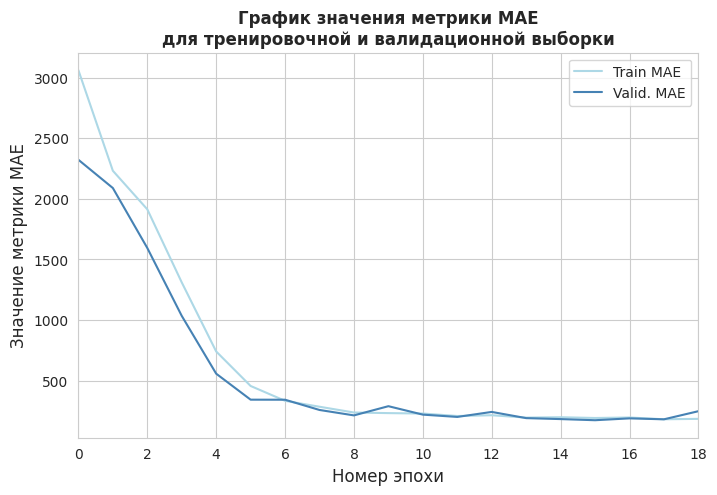

In [ ]:
mae_plot(None, hist_df)

In [ ]:
y_pred = model.predict(X_test_scaled)

63/63 [==============================] - 0s 2ms/step


In [ ]:
y_pred

array([[1283.431 ],
       [1533.7731],
       [6805.822 ],
       ...,
       [2317.9614],
       [6862.7095],
       [8238.585 ]], dtype=float32)

In [ ]:
y_test

array([1255.86654581, 1544.839941  , 6792.11454264, ..., 2329.9177729 ,
       6547.97221705, 8332.07646941])

In [ ]:
print_metrics(y_test, y_pred, X_train, None)

{'train_size0': 8000, 'train_size1': 1000, 'lmbd_val': 9999.31040755012, 'mse': 101176.30600582362, 'mae': 230.17559850336585, 'r2': 0.9876046548540905}


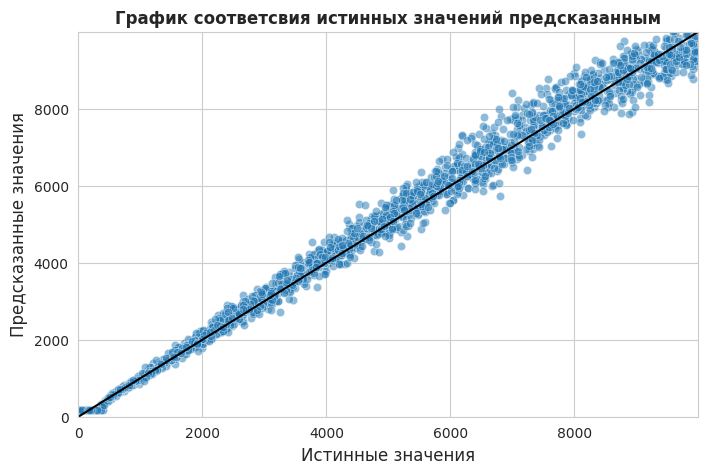

In [ ]:
scatter_plot(y_test, y_pred, max(y_test), None)

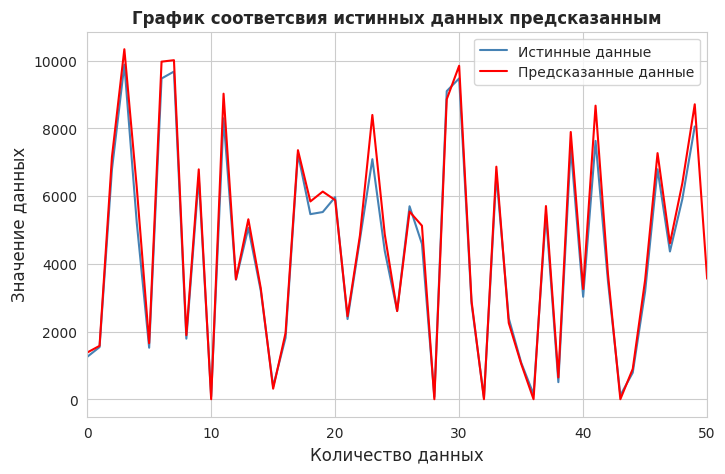

In [ ]:
line_plot(y_test, y_pred, 50, None)

# Tune

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def build_model(hp):
    dnn_layers_ss = [1,2,3,4]
    dnn_units_min, dnn_units_max = 32, 512
    active_func_ss = ['relu']
    optimizer_ss = ['adam']
    lr_min, lr_max = 1e-4, 1e-1

    active_func = hp.Choice('activation', active_func_ss)
    optimizer = hp.Choice('optimizer', optimizer_ss)
    lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')

    inputs = Input(shape=(X_train.shape[1],))

    # create hidden layers
    dnn_units = hp.Int(f"0_units", min_value=dnn_units_min, max_value=dnn_units_max)
    dense = Dense(units=dnn_units, activation=active_func)(inputs)
    for layer_i in range(hp.Choice("n_layers", dnn_layers_ss) - 1):
        dnn_units = hp.Int(f"{layer_i}_units", min_value=dnn_units_min, max_value=dnn_units_max)
        dense = Dense(units=dnn_units, activation=active_func, kernel_regularizer=regularizers.l2(0.001))(dense)
        if hp.Boolean("dropout"):
          Dropout(0.5)(dense)
    outputs = Dense(units=1)(dense)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics='mae')
    return model

pois_reg_best_model_hyperband_4layers_50epochs

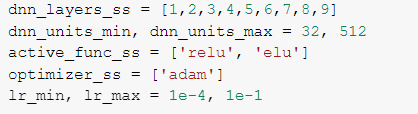

# Hyperband

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     overwrite=True,
                     max_epochs=5,
                     factor=3,
                     directory='/content/drive/MyDrive/maga/tune',
                     project_name='pois_reg_hyperband_1')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(
    X_train_scaled,
    y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

Trial 10 Complete [00h 00m 06s]
val_mae: 302.18768310546875

Best val_mae So Far: 163.29913330078125
Total elapsed time: 00h 01m 00s


# Bayesian

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=30,
    overwrite=True,
    directory='/content/drive/MyDrive/maga/tune',
    project_name='pois_bayesian_1')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(
    X_train_scaled,
    y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

Trial 30 Complete [00h 00m 11s]
val_mae: 136.0135955810547

Best val_mae So Far: 134.79002380371094
Total elapsed time: 00h 06m 42s


# Train model

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'activation': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.033729162143222746,
 '0_units': 394,
 'n_layers': 4,
 'dropout': False,
 '1_units': 275,
 '2_units': 280}

In [ ]:
best_model = tuner.get_best_models()[0]

best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 394)               394394    
                                                                 
 dense_1 (Dense)             (None, 394)               155630    
                                                                 
 dense_2 (Dense)             (None, 275)               108625    


 dense_3 (Dense)             (None, 280)               77280     


 dense_4 (Dense)             (None, 1)                 281       


Total params: 736,210


Trainable params: 736,210


Non-trainable params: 0
_________________________________________________________________


In [ ]:
def myprint(s):
    with open('/content/drive/MyDrive/maga/model_summary/pois_reg_interval_bayesianoptimization_5layers_70epochs_r2_89.txt','a') as f:
        print(s, file=f)

best_model.summary(print_fn=myprint)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, epochs=70, validation_split=0.2, callbacks=[stop_early])

Epoch 1/70
200/200 [==============================] - 7s 22ms/step - loss: 112206032.0000 - mae: 3427.8584 - val_loss: 4253306.0000 - val_mae: 1760.1980
Epoch 2/70
200/200 [==============================] - 3s 13ms/step - loss: 1062856.8750 - mae: 764.2579 - val_loss: 440164.5625 - val_mae: 543.5721
Epoch 3/70
200/200 [==============================] - 2s 12ms/step - loss: 182464.0000 - mae: 333.3691 - val_loss: 140238.4844 - val_mae: 287.6143
Epoch 4/70
200/200 [==============================] - 2s 12ms/step - loss: 175232.9219 - mae: 326.3411 - val_loss: 337013.4062 - val_mae: 461.2692
Epoch 5/70
200/200 [==============================] - 3s 13ms/step - loss: 138597.0469 - mae: 288.2138 - val_loss: 304482.4688 - val_mae: 433.2838
Epoch 6/70
200/200 [==============================] - 4s 20ms/step - loss: 173494.5625 - mae: 315.5332 - val_loss: 105465.6172 - val_mae: 249.0443
Epoch 7/70
200/200 [==============================] - 3s 15ms/step - loss: 131638.9688 - mae: 280.7697 - val_lo

In [ ]:
y_pred = model.predict(X_test_scaled)

63/63 [==============================] - 0s 3ms/step


In [ ]:
y_pred

array([[1120.4287],
       [1836.7504],
       [7550.4106],
       ...,
       [2660.05  ],
       [7338.449 ],
       [9240.516 ]], dtype=float32)

In [ ]:
y_test

array([1255.86654581, 1544.839941  , 6792.11454264, ..., 2329.9177729 ,
       6547.97221705, 8332.07646941])

In [ ]:
print_metrics(y_test, y_pred, X_train, None)

{'train_size0': 8000, 'train_size1': 1000, 'lmbd_val': 9999.31040755012, 'mse': 324646.040386426, 'mae': 461.49092197301553, 'r2': 0.9602268566653244}


In [ ]:
print_metrics(y_test, y_pred, X_train, 'pois_reg_interval_bayesianoptimization_5layers_70epochs_r2_89')

{'train_size0': 8000, 'train_size1': 1000, 'lmbd_val': 9999.31040755012, 'mse': 880273.0379756859, 'mae': 749.8991954835998, 'r2': 0.8921556977211752}


In [ ]:
hist_df = pd.DataFrame(history.history)

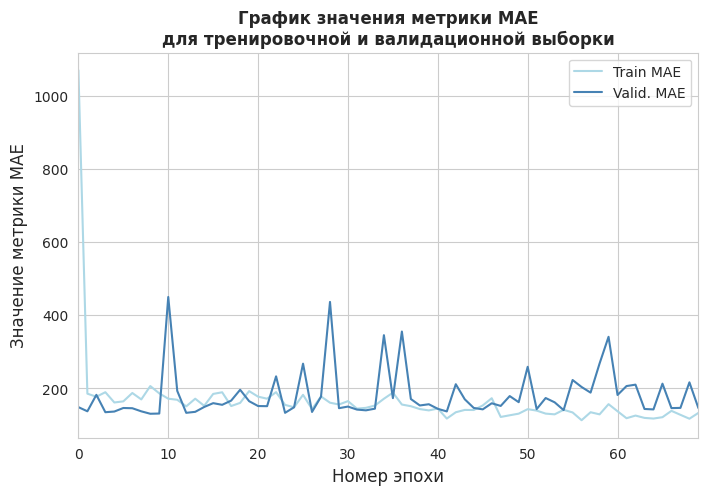

In [ ]:
mae_plot('pois_reg_interval_bayesianoptimization_5layers_70epochs_r2_89', hist_df)

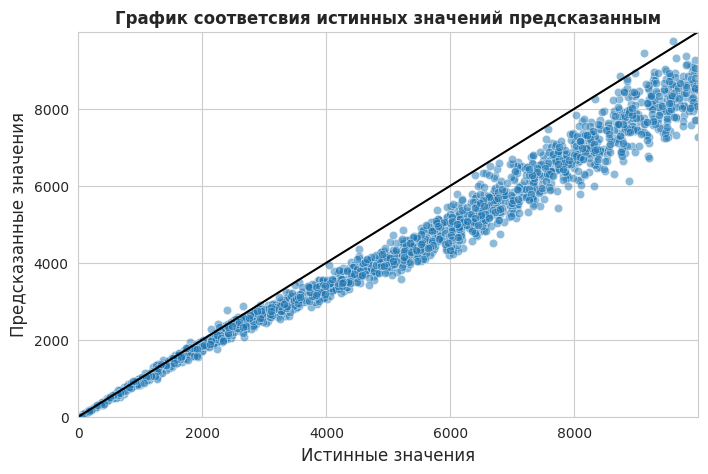

In [ ]:
scatter_plot(y_test, y_pred, max(y_test), 'pois_reg_interval_bayesianoptimization_5layers_70epochs_r2_89')

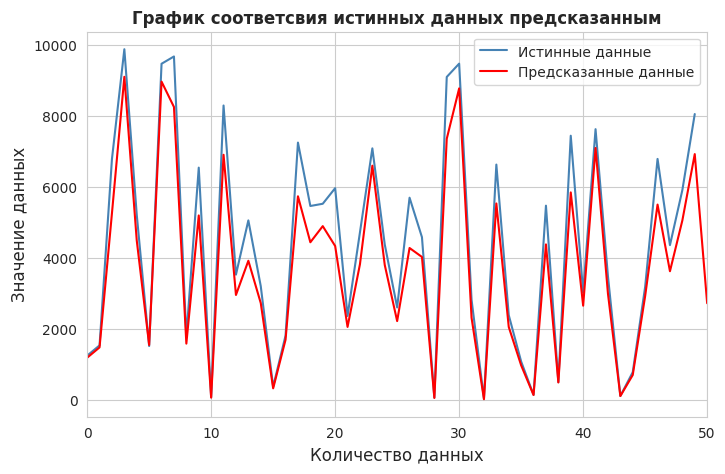

In [ ]:
line_plot(y_test, y_pred, 50, 'pois_reg_interval_bayesianoptimization_5layers_70epochs_r2_89')